In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 100

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def show_ts(ts, forecast=None, title="Title", sampling="Samplingrate"):
    ax = ts.plot(label = "Observed", figsize=(10,3))
    if not (forecast is None):
        forecast.plot(ax=ax, label='Forecast')
        plt.legend()

    ax.set_xlabel('Date')
    ax.set_ylabel('Messages/'+sampling)
    plt.title(title)
    plt.show()

In [ ]:
# Load data into memory
dataset_names = ["avazu","IoT","wiki_de","wiki_en","horton","retailrocket","taxi","alibaba","google"]
sampling_rate = ["1h","15min","5min"]

datasets = {}  # {dataset_name: {sampling_rate: df}}

for dataset_name in dataset_names:
    datasets[dataset_name] = {}
    for sampling_rate in sampling_rates:
        results_statistical = pd.read_csv(f"results/{dataset_name}_{sampling_rate}_results.csv", index_col=0, parse_dates=True)
        results_gru = pd.read_csv(f"dl_experiments/results/{dataset_name}_{sampling_rate}_cuda:0_results.csv", index_col=0, parse_dates=True)["GRU"]
        
        df = pd.concat([results_statistical, results_gru], axis=1)
        df.name = f"{dataset_name}_{sampling_rate}"
        datasets[dataset_name][sampling_rate] = df
datasets

In [ ]:
# Print SMAPE
for dataset_name, x in datasets.items():
    print(dataset_name)
    for sampling_rate, df in x.items():
        print("\t"+sampling_rate)
        models = results.columns[1:]
        for model in models:
            print(f"\t\t{model}: {smape(results.t,results[model]):.2f}")
            model_smape[m] = smape(results.t,results[model])

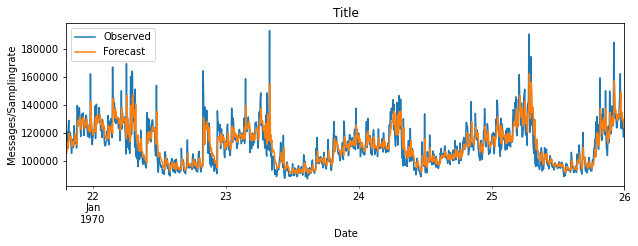

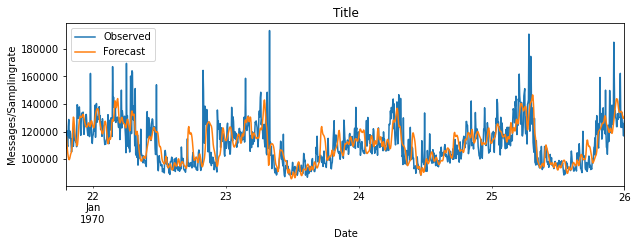

In [40]:
show_ts(results.t, results.ARIMA)
show_ts(results.t, results.SARIMA)

In [41]:
durations = pd.read_csv("results/durations.csv")
display(durations)

,dataset,sampling_rate,SARIMA_opt,SARIMA_tune,LASTOBSERVED,ARIMA_opt,ARIMA_tune,SimpleExpSmoothing,SimpleExpSmoothing_tune,ExpSmoothing,ExpSmoothing_tune,Prophet,Prophet_tune
0,avazu,1h,304.225096,1.162240,0.001118,1.162102,0.012148,0.005414,0.005989,0.037405,0.018584,0.689940,0.054385
1,avazu,15min,1288.256112,25.055953,0.000706,9.580455,0.076839,0.004212,0.007159,0.069858,0.042675,0.200897,0.105732
2,avazu,5min,NaN,NaN,0.000718,39.769271,0.291401,0.006685,0.010411,0.499798,0.130122,1.046018,0.224534
3,IoT,1h,235.632510,0.067819,0.000709,4.308953,0.029441,0.004894,0.006423,0.038814,0.021879,0.074572,0.067153
4,IoT,15min,2061.989176,8.137557,0.000734,15.696772,0.193426,0.005194,0.008519,0.079805,0.051092,0.432779,0.143742
5,IoT,5min,NaN,NaN,0.000753,35.072346,1.146911,0.009254,0.014450,0.619137,0.158560,3.460655,0.338780
6,wiki_de,1h,205.504381,0.061815,0.000715,4.625229,0.054853,0.004600,0.006422,0.038386,0.022059,0.124040,0.088371
7,wiki_de,15min,2907.406277,4.497017,0.000716,6.867576,0.094000,0.005208,0.008464,0.077690,0.050837,0.842817,0.188467
8,wiki_de,5min,NaN,NaN,0.000775,27.670827,0.228568,0.010075,0.014562,0.541803,0.437855,2.588192,0.355610
9,wiki_en,1h,310.602459,1.040674,0.000700,2.292106,0.037227,0.004454,0.006915,0.039346,0.022749,0.193899,0.086162


<AxesSubplot:xlabel='date'>

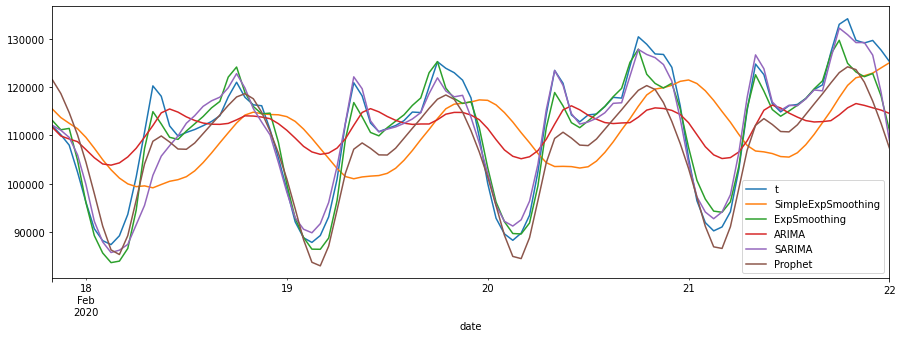

In [52]:
pd.read_csv("results/taxi_1h_results.csv", index_col=0, parse_dates=True).drop(columns=["LASTOBSERVED", "LASTDAY"]).plot(figsize=(15,5))